In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers.descriptors import Section

In [10]:
sections = []

for i in range(20):
    data = np.loadtxt(f"../../real_data/GrotteDeLaCascadeDeMotiers/sections_as_polylines/unordered_section_{i}.txt")
    sections.append(data)
    
    

Text(0.5, 1.0, 'distribution of ou-of-plane residuals after section transformations')

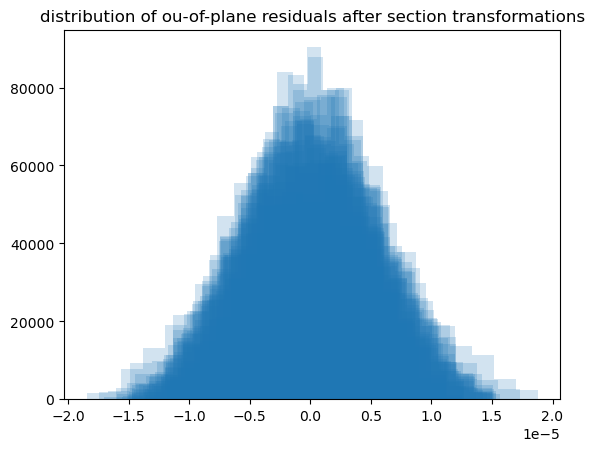

In [11]:
for data in sections:
    plt.hist(data[:, 1] - np.mean(data[:, 1]), density = True, alpha = 0.2, bins = 20, color = "C0")

plt.title("distribution of ou-of-plane residuals after section transformations")

In [12]:
def order_points(points, ind):
    points_new = [ points.pop(ind) ]  # initialize a new list of points with the known first point
    pcurr      = points_new[-1]       # initialize the current point (as the known point)
    k = 0
    while len(points)>0 and k <= 1e4:
        d      = np.linalg.norm(np.array(points) - np.array(pcurr), axis=1)  # distances between pcurr and all other remaining points
        ind    = d.argmin()                   # index of the closest point
        points_new.append( points.pop(ind) )  # append the closest point to points_new
        pcurr  = points_new[-1]               # update the current point
        k+=1
    if k == 1e4:
        print("max iterations reached")
    return np.array(points_new)

In [13]:
ordered = []

for data in sections:
    data = order_points(data.tolist(), 0)
    dists = np.sqrt((np.diff(data, axis = 0)**2).sum(axis = 1))
    id0 = 0
    idx = -1
    if np.any(dists > 0.2):
        print("likely several segments")
        split = np.argmax(dists)
        print(idx)
        print(len(data))
        if split < len(data) / 2:
            data = data[split:idx]
        else:
            data = data[id0:split]
        

    # check if closed: 
    closure = np.sqrt(((data[-1] - data[0])**2).sum())
    if closure > 0.1:
        print("there may be a closure error")
        s = Section(data, flag= "ClosureError")
    else: 
        s = Section(data, flag= "all ok")
    ordered.append(s)


likely several segments
-1
1344
likely several segments
-1
1456
there may be a closure error
likely several segments
-1
1434
likely several segments
-1
1476


In [17]:
for section in ordered:
    section.compute_descriptors()
    section.print_basic_stats()

Basic stats for the chosen section
------------------------------------

Perimeter : 12.50m
Area :  9.41 m2
Hydraulic diameter :  3.01m
Solidity :  0.95
Circularity :  0.76

Basic stats for the chosen section
------------------------------------

Perimeter : 12.56m
Area :  8.58 m2
Hydraulic diameter :  2.73m
Solidity :  0.92
Circularity :  0.68

Basic stats for the chosen section
------------------------------------

Perimeter : 13.44m
Area :  8.61 m2
Hydraulic diameter :  2.56m
Solidity :  0.89
Circularity :  0.60

Basic stats for the chosen section
------------------------------------

Perimeter : 13.94m
Area :  8.71 m2
Hydraulic diameter :  2.50m
Solidity :  0.86
Circularity :  0.56

Basic stats for the chosen section
------------------------------------

Perimeter : 13.25m
Area :  9.45 m2
Hydraulic diameter :  2.85m
Solidity :  0.92
Circularity :  0.68

Basic stats for the chosen section
------------------------------------

Perimeter : 14.67m
Area : 10.04 m2
Hydraulic diameter :  